In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from tqdm import tqdm
import torch
from khammash_repro import *

In [3]:
Kp = 5.9055e3 #/ 800
Ki = 3.0382 #/ 1
Kd = 0
Kbc = 0.0

pid_par = (Kp, Ki, Kd, Kbc)

phi_p0 = 0.41
L0 = 800

sp_arr = np.array([0.2, 0.8, 0.4])
t_arr = np.array([30,30,30])

sampling_time = 0.5
time_resolution = 0.1

In [5]:
   
Kp, Ki, Kd, Kbc = pid_par

initial_cond = get_init_cond(L0=L0)
initial_cond[-1] = phi_p0

if np.isscalar(sp_arr):
    sp_arr = np.array([sp_arr])
if np.isscalar(t_arr):
    t_arr = np.array([t_arr])

def sp_fun(t):
    if t >= np.sum(t_arr):
        sp = sp_arr[-1]
    else:
        sp = sp_arr[np.argmax(np.cumsum(t_arr) > t)]
    return sp

if len(sp_arr) != len(t_arr):
    raise ValueError('sp_arr and t_arr must have the same length')

output_y = []
output_t = []
output_L = []
output_sp = []
error_arr = []
error_accum_arr = []
prop_arr = []
int_arr = []
der_arr = []
bc_arr = []

t_first = 0
t_last = np.sum(t_arr)
t_next = t_first + sampling_time

# Initial Controller Action
# Compute error
sp = sp_fun(0)
error = sp - phi_p0
error_old = error
error_accum = 0

# Compute integral
error_accum = error_accum + error * (sampling_time * 60)

# Compute output
u_compute = round(Kp * error + Kd * (error - error_old)/(sampling_time * 60) + Ki * error_accum)

# Saturation
u = np.clip(u_compute, 0, 800)
L = u #* 800

# Back-calculation (anti-windup)
bc = u - u_compute
error_accum = error_accum + bc * Kbc

error_old = error
# output_y.append(initial_cond.reshape(-1,1))
# output_t.append(np.array([0]))
# output_L.append(np.array([L]))
# output_sp.append(np.array(sp_fun(0)))

while t_next <= t_last:
    # print(t_next, L)
    t_eval = np.arange(t_first*60, t_next*60, time_resolution*60)
    sol = solve_ivp(ode_fun, [t_first*60, t_next*60], initial_cond, args=(L,), method='BDF', t_eval=t_eval, atol=1e-10, rtol=1e-10)
    output_y.append(sol.y[:,:])
    output_t.append(sol.t[:])
    output_L.append(np.ones(len(sol.t[:])) * L)
    output_sp.append(np.ones(len(sol.t[:])) * sp_fun(t_next))
    initial_cond = sol.y[:,-1]
    t_first = t_next
    t_next = t_next + sampling_time

    # Compute new L
    phi_p = sol.y[3,-1]
    sp = sp_fun(t_next)
    error = sp - phi_p

    # If setpoint has changed
    # if sp != sp_old:
    #     error_old = error
    #     error_accum = 0
    #     sp_old = sp
    #     u0 = u

    # Compute integral
    error_accum = error_accum + error * (sampling_time * 60)
    
    # Compute output
    u_compute = np.round(Kp * error + Kd * (error - error_old)/(sampling_time * 60) + Ki * error_accum)

    # Saturation
    u = np.clip(u_compute, 0, 800)
    L = u #* 800

    # Back-calculation (anti-windup)
    bc = u - u_compute
    error_accum = error_accum + bc * Kbc

    error_old = error

    error_arr.append(error)
    error_accum_arr.append(error_accum)
    prop_arr.append(Kp * error)
    int_arr.append(Ki * error_accum)
    der_arr.append(Kd * (error - error_old)/(sampling_time * 60))
    bc_arr.append(bc * Kbc)

output_y = np.hstack(output_y)
output_t = np.hstack(output_t) / 60
output_L = np.hstack(output_L)
output_sp = np.hstack(output_sp)

error_arr = np.hstack(error_arr)
error_accum_arr = np.hstack(error_accum_arr)
prop_arr = np.hstack(prop_arr)
int_arr = np.hstack(int_arr)
der_arr = np.hstack(der_arr)
bc_arr = np.hstack(bc_arr)

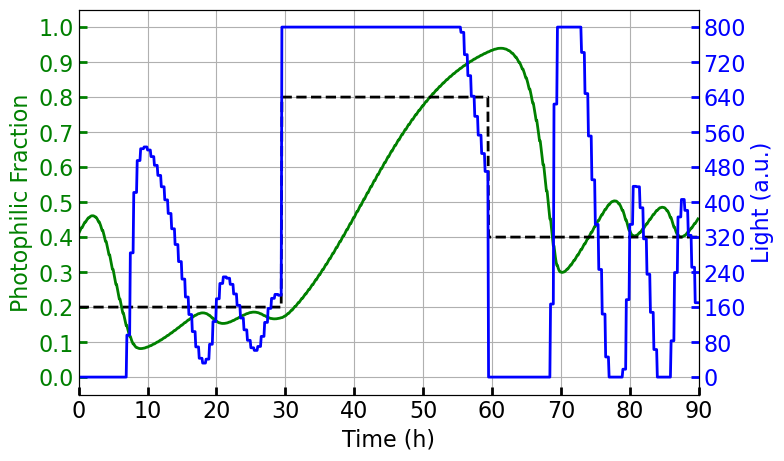

In [6]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ax.plot(output_t, output_y[-1,:], color = 'green', linewidth = 2, label = 'Photophilic Fraction')
ax.plot(output_t, output_sp, color = 'black', linestyle='dashed', linewidth = 2, label = 'Setpoint')
ax.set_ylim([-0.05, 1.05])
ax.set_xlim([0, np.sum(t_arr)])
ax.set_xlabel('Time (h)', fontsize = 16)
ax.set_ylabel('Photophilic Fraction', fontsize = 16, color = 'green')
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
ax.tick_params(axis='y', which='major', labelsize=16, width=2, length=6, direction='in', colors='green')
ax.tick_params(axis='x', which='major', labelsize=16, width=2, length=6, direction='in')
ax.grid()

ax2 = ax.twinx()
ax2.plot(output_t, output_L, color = 'blue', linewidth = 2, label = 'Light')
ax2.set_ylim([-40, 840])
ax2.set_yticks([0, 80, 160, 240, 320, 400, 480, 560, 640, 720, 800])
ax2.set_ylabel('Light (a.u.)', fontsize = 16, color = 'blue')
ax2.tick_params(axis='y', which='major', labelsize=16, width=2, length=6, direction='in', colors='blue')

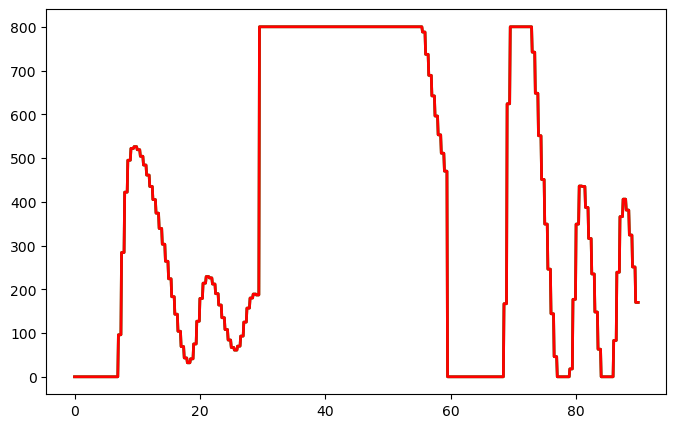

In [20]:
index = 0

my_phi = output_y[3,:]
my_sp = output_sp
my_L = output_L
my_t = output_t

Kp, Ki, Kd, Kbc = pid_par

my_L_pred = np.zeros_like(my_L)

error_accum = 0
error_old = my_sp[0] - my_phi[0]

sampling_time = 0.1
control_time = 0.5

error_arr_test = []
error_accum_arr_test = []
prop_arr_test = []
int_arr_test = []
der_arr_test = []
bc_arr_test = []


for i in range(0, len(my_L)):
    if not i % int(control_time / sampling_time) == 0:
        my_L_pred[i] = my_L_pred[i-1]
        continue
    # print(my_t[i])

    phi_val = my_phi[i]
    sp_val = my_sp[i]
    
    error = sp_val - phi_val

    error_accum += error * control_time * 60

    u_compute = round(Kp * error + Ki * error_accum + Kd * (error - error_old) / (control_time * 60))

    u = np.clip(u_compute, 0, 800)

    bc = u - u_compute
    error_accum = error_accum + bc * Kbc

    error_old = error

    my_L_pred[i] = u

    error_arr_test.append(error)
    error_accum_arr_test.append(error_accum)
    prop_arr_test.append(Kp * error)
    int_arr_test.append(Ki * error_accum)
    der_arr_test.append(Kd * (error - error_old)/(control_time * 60))
    bc_arr_test.append(bc * Kbc)

error_arr_test = np.hstack(error_arr_test)
error_accum_arr_test = np.hstack(error_accum_arr_test)
prop_arr_test = np.hstack(prop_arr_test)
int_arr_test = np.hstack(int_arr_test)
der_arr_test = np.hstack(der_arr_test)
bc_arr_test = np.hstack(bc_arr_test)

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)

ax.plot(my_t, my_L, color = 'green', linewidth = 2)
ax.plot(my_t, my_L_pred, color = 'red', linewidth = 2)
